In [1]:
import glob
import os

import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

mtcnn = MTCNN(device=device)

Using device: cuda


In [3]:
class SiblingsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        persons = os.listdir(root_dir)
        for p in persons:
            sub = os.path.join(root_dir, p)
            if not os.path.isdir(sub):
                continue

            imgs = glob.glob(os.path.join(sub, "*.jpg"))
            for img in imgs:
                csv = img.replace(".jpg", ".csv")
                if os.path.exists(csv):
                    self.samples.append((img, csv))

    def __len__(self):
        return len(self.samples)

    def load_landmarks(self, csv_path):
        arr = np.loadtxt(csv_path, delimiter=",", usecols=(1, 2), skiprows=1)
        arr = arr.flatten()  # shape → (152,) there are 76 landmarks (x, y)
        return torch.tensor(arr, dtype=torch.float32)

    def __getitem__(self, idx):
        img_path, csv_path = self.samples[idx]

        img = Image.open(img_path).convert("RGB")

        face = mtcnn(img)
        if face is None:
            face = img
        else:
            face = face.permute(1, 2, 0).int().numpy().astype(np.uint8)
            face = Image.fromarray(face)

        if self.transform:
            face = self.transform(face)

        landmarks = self.load_landmarks(csv_path)

        return face, landmarks

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [5]:
dataset = SiblingsDataset("data/DBs/HQf/", transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)
print("Dataset size:", len(dataset))

Dataset size: 180


In [6]:
sample_img, sample_lm = dataset[0]
num_outputs = sample_lm.shape[0]
print("Number of landmark outputs:", num_outputs)

Number of landmark outputs: 152


In [7]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_outputs)
model = model.to(device)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [9]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for imgs, targets in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}: Loss={total_loss / len(loader):.4f}")

Epoch 1/20: Loss=3314573.4583
Epoch 2/20: Loss=3375320.7083
Epoch 3/20: Loss=3356924.1667
Epoch 4/20: Loss=3306050.7500
Epoch 5/20: Loss=3354903.2500
Epoch 6/20: Loss=3350338.0000
Epoch 7/20: Loss=3346323.9583
Epoch 8/20: Loss=3316429.1667
Epoch 9/20: Loss=3342598.0208
Epoch 10/20: Loss=3325960.1667
Epoch 11/20: Loss=3332092.4167
Epoch 12/20: Loss=3325504.2292
Epoch 13/20: Loss=3331549.1458
Epoch 14/20: Loss=3317235.0833
Epoch 15/20: Loss=3322201.8958
Epoch 16/20: Loss=3296049.7917
Epoch 17/20: Loss=3318061.0417
Epoch 18/20: Loss=3258763.8958
Epoch 19/20: Loss=3299038.9583
Epoch 20/20: Loss=3311721.8542


In [ ]:
def predict_landmarks(img_path):
    img = Image.open(img_path).convert("RGB")

    face = mtcnn(img)
    if face is None:
        raise ValueError("No face detected")

    face = face.permute(1, 2, 0).int().numpy().astype(np.uint8)
    face = Image.fromarray(face)

    face = transform(face).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(face).cpu().numpy().reshape(-1, 2)

    return pred

In [14]:
def show_landmarks(img_path, landmarks):
    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    for x, y in landmarks:
        plt.scatter(x, y, s=10, c="red")
    plt.axis("off")
    plt.show()

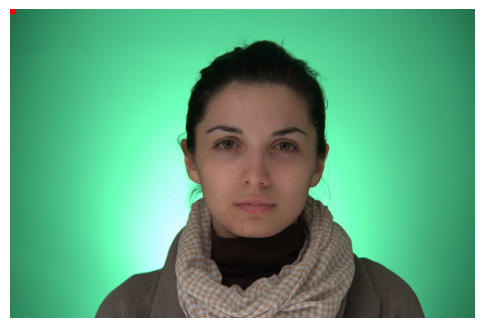

In [15]:
landmarks = predict_landmarks("data/DBs/HQf/1/_DSC5755_1.jpg")
show_landmarks("data/DBs/HQf/1/_DSC5755_1.jpg", landmarks)